In [160]:
# %matplotlib qt

import os
from tqdm import tqdm
import sys
import cv2
import csv
import scipy as sp
import pdb

sys.setrecursionlimit(10000)  # pour la fonction de contournement recursive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random as rd
from PIL import Image
from tqdm import tqdm
import traceback

import sklearn  # scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier

from skimage.segmentation import clear_border
from skimage.morphology import opening, closing, disk

from skimage import exposure
from skimage.filters import threshold_otsu



'''
An idea to do the segmentation : After use k-means clustering on the whole image so as to differentiate the skin from the nevus.
This would divide the pixels into two clusters. Then I could use sinusoïdale fit with low order regression to get a segmentation of the nevus. 
'''




'\nAn idea to do the segmentation : After use k-means clustering on the whole image so as to differentiate the skin from the nevus.\nThis would divide the pixels into two clusters. Then I could use sinusoïdale fit with low order regression to get a segmentation of the nevus. \n'

In [161]:
def LoadandTreat_images(image_path, mask_path, show=False):
    ''' Pour les fichiers possédant déjà un masque dans la database. '''
    image=cv2.imread(image_path,cv2.IMREAD_COLOR)

    ### Apply DullRazor Algorithme to remove hair
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )               # Gray scale
    kernel = cv2.getStructuringElement(1,(20,20)) # (9,9) initialy     # select kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) # Black hat filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)           # Gaussian filter
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)             # Binary thresholding (MASK)
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)                  # Replace pixels of the mask
    
    ### Apply Mask to the image
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    if show :
        plt.imshow(mask)
        plt.show()

    # Erode the mask to remove all the skin
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 5) # erode the mask to remove all the skin on borders, enables better color segmentation
    # mask = cv2.erode(mask,kernel,iterations = 1) # additional erosion to remove the skin on the borders

    try :
        image=cv2.bitwise_and(dst,dst,mask=mask)
        # appliquer erosion
    except:
        print(str(mask_path).split('/')[-1])
        print(mask.shape)  # Should print the same shape as 'dst'
        print(str(image_path).split('/')[-1])
        print(dst.shape)
        print(np.unique(mask))  # Should print only 0 and 255
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # permet de convertir l'image en RGB (openCV lie par défaut du BGR)
    return image

def create_nevus_mask(image, dark_threshold=90, show=False):

    pixels = image.reshape(-1, 3)
    height, width = image.shape[:2]

    #### !  The first step is to check whether there is a dark cluster : perform k-means clustering with 3 colors
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(pixels)
    mean_colors = kmeans.cluster_centers_      # Find the mean color of each cluster
    brightness = np.mean(mean_colors, axis=1)  # Check if any of the mean colors is below the dark threshold
    dark_cluster = brightness < dark_threshold
    if show:
        plt.imshow(image)
        plt.show()

    #### ! If we have a dark cluster, it musn't be taken into account when segmenting the nevus, we take only the non-dark pixels
    if True in dark_cluster:
        darkest_cluster_index = np.argmin(brightness)  # Find the index of the darkest cluster

        labels = kmeans.labels_                        # Create a mask for the darkest cluster only
        dark_pixels_mask = labels.reshape(image.shape[:2]) == darkest_cluster_index

        ### ? We Create a mask to identify non-dark pixels, enabling to be more accurate when segmenting the nevus
        non_dark_pixels_mask = ~dark_pixels_mask                                     # We take the opposite of the dark pixels to get a mask of non dark pixels
        non_dark_pixels_mask = sp.ndimage.binary_fill_holes(non_dark_pixels_mask)    # Fill holes in the non-dark pixels mask, prevent having holes on the nevus area, which can be dark.

        kernel = np.ones((30,30),np.uint8)
        non_dark_pixels_mask = non_dark_pixels_mask.astype(np.uint8)  # converting to uint8
        non_dark_pixels_mask = cv2.erode(non_dark_pixels_mask,kernel,iterations = 1) # we erode the mask to remove some skin on the borders, prevents ending with a large ring of skin when segmenting the nevus
        non_dark_pixels_mask = non_dark_pixels_mask.astype(bool)      # converting back to boolean
        if show :
            print('Dark cluster found')
            plt.imshow(non_dark_pixels_mask)
            plt.title("Non-dark pixels mask")
            plt.show()
        non_dark_pixels = pixels[non_dark_pixels_mask.flatten()]                     # Extract non-dark pixels

        ### ? Do the nevus clustering on the non-dark pixels only
        kmeans = KMeans(n_clusters=2, random_state=42)                # ! k-means clustering with 2 colors is much more accurate without dark pixels
        kmeans.fit(non_dark_pixels)                                   # !
        if show:
            cluster_img_1 = np.zeros_like(pixels) # Plot the clusters for each label separately
            cluster_img_2 = np.zeros_like(pixels)
            cluster_img_1[non_dark_pixels_mask.flatten()] = (kmeans.labels_ == 0).astype(int)[:, None] * [0,0,255] # one cluster in blue
            cluster_img_2[non_dark_pixels_mask.flatten()] = (kmeans.labels_ == 1).astype(int)[:, None] * [255,0,0] # the other in red
            cluster_img_1 = cluster_img_1.reshape((height, width, 3)) # Reshape the flattened cluster image back to the original image dimensions (height, width, 3)
            cluster_img_2 = cluster_img_2.reshape((height, width, 3))
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("K-means Cluster Label 0")
            plt.imshow(cluster_img_1)
            plt.subplot(1, 2, 2)
            plt.title("K-means Cluster Label 1")
            plt.imshow(cluster_img_2)
            plt.show()
        
        ### ? We calculate the centers of the clusters and the mean distances of the pixels to the centers in order to differentiate the nevus from the skin
        ### The idea is to find the cluster which is nearer to it's own center
        centers = np.zeros((2, 2))  # store the centers
        mean_distances = np.zeros(2)  # store the mean distances
        pctg = 0.008
        for i in range(2):
            # Get the coordinates of the pixels in this cluster
            local_mask = np.zeros(height * width, dtype=bool)                  # Initialize a full-sized mask with zeros
            local_mask[non_dark_pixels_mask.flatten()] = (kmeans.labels_ == i) # Update only the positions corresponding to the non-dark pixels, local mask for current cluster
            cluster_mask = local_mask.reshape((height, width))                 # Reshape the mask to the original image dimensions
            coords = np.argwhere(cluster_mask)

            num_pixels = coords.shape[0]
            num_sample = int(num_pixels * pctg)
            indices = np.random.choice(num_pixels, num_sample, replace=False)     # Randomly select a poourcentage of the pixels (fasten the computation)
            sample_coords = coords[indices]
            if sample_coords.size == 0:
                print("Empty sample_coords")
            
            centers[i] = sample_coords.mean(axis=0)                               # Compute the mean of the sample coordinates
            if show:
                plt.scatter(centers[i][1], centers[i][0])
                plt.scatter(sample_coords[:, 1], sample_coords[:, 0], s=1)
            distances = np.sqrt(np.sum((sample_coords - centers[i])**2, axis=1))  # Compute the distance between the center and each sample point
            mean_distances[i] = distances.mean()                                  # Compute the mean of the distances
        
        if show:
            plt.title("Cluster Centers and Sample Points to determine the inner cluster")
            plt.show()

        nevus_label = np.argmin(mean_distances)          # Assume the nevus is the cluster with the smallest mean distance to its center

        ### We put the non-dark pixels back to their original position in the image
        labels = kmeans.labels_
        full_mask = non_dark_pixels_mask.flatten()
        full_mask[full_mask] = (labels == nevus_label)   # assign the cluster whose points are the closest to its center
        nevus_mask = full_mask.reshape((height, width))  # Reshape the mask to the image dimensions

    #### ! If there is no dark cluster, we just use the same technique as before, but on the whole image
    else:
        n_c = 2
        kmeans = KMeans(n_clusters=n_c) # perform k-means clustering with 2 colors on the whole image
        kmeans.fit(pixels)


        centers = np.zeros((n_c, 2))
        mean_distances = np.zeros(n_c)
        pctg = 0.008
        for i in range(n_c):
            # Get the coordinates of the pixels in this cluster
            cluster_mask = (kmeans.labels_ == i).reshape(height, width)  # Create a mask for the current cluster
            coords = np.argwhere(cluster_mask)

            num_pixels = coords.shape[0]
            num_sample = int(num_pixels * pctg)
            indices = np.random.choice(num_pixels, num_sample, replace=False)    # Randomly select a percentage of the pixels (fasten the computation)
            sample_coords = coords[indices]

            centers[i] = sample_coords.mean(axis=0)                              # Compute the mean of the sample coordinates
            if show:
                plt.scatter(centers[i][1], centers[i][0])
                plt.scatter(sample_coords[:, 1], sample_coords[:, 0], s=1)
            distances = np.sqrt(np.sum((sample_coords - centers[i])**2, axis=1)) # Compute the distance between the center and each sample point
            mean_distances[i] = distances.mean()                                 # Compute the mean of the distances
        if show:
            plt.title("Cluster Centers and Sample Points to determine the inner cluster")
            plt.show()

        nevus_label = np.argmin(mean_distances)                             # Assume the nevus is the cluster with the smallest mean distance to its center
        nevus_mask = (kmeans.labels_ == nevus_label).reshape(height, width) # Create a binary mask for the nevus
    
    if show:
        plt.title("Nevus Mask, before keeping the largest component")
        plt.imshow(nevus_mask)
        plt.show()

    ### ! Fill holes in the binary image
    nevus_mask = sp.ndimage.binary_fill_holes(nevus_mask)
    
    ### ! Keep only the largest connected component
    labeled_mask, num_features = sp.ndimage.label(nevus_mask)
    sizes = np.bincount(labeled_mask.ravel())
    sizes[0] = 0  # background is considered as a component, we ignore it
    largest_label = sizes.argmax()
    largest_component = (labeled_mask == largest_label) # .astype(np.uint8)

    return largest_component

def create_and_apply_mask(image, dark_threshold=90, show1=False):
    
    ### Apply DullRazor Algorithme to remove hair
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )               # Gray scale
    kernel = cv2.getStructuringElement(1,(9,9)) # (9,9) initialy     # select kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) # Black hat filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)           # Gaussian filter
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)             # Binary thresholding (MASK)
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)                  # Replace pixels of the mask

    ### create and apply Mask to the image
    mask = create_nevus_mask(dst, dark_threshold=dark_threshold, show=show1)
    mask = (mask * 255).astype(np.uint8)
    mask = smooth_mask_gaussian(mask)
    masked_image = cv2.bitwise_and(dst, dst, mask=mask)

    return masked_image



def smooth_mask_gaussian(mask, kernel_size=35):
    '''
    This function smooths the borders of a binary mask using Gaussian blur.
    The kernel_size parameter determines the size of the kernel used for blurring.
    '''
    # Apply Gaussian blur to the binary mask
    blurred_mask = cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)
    
    # Threshold the blurred mask to get a binary mask again
    _, smoothed_mask = cv2.threshold(blurred_mask, 190, 255, cv2.THRESH_BINARY)#127 up to 200 to get a natural erosion
    
    return smoothed_mask


In [ ]:
def show_images(original_image_path, mask):
    # Read the original image
    original_image = cv2.imread(original_image_path)

    # Display the original image and the mask
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Nevus Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.show()

# Example usage
image_path = 'path/to/your/nevus/image.jpg'
mask = segment_nevus(image_path)
if mask is not None:
    show_images(image_path, mask)
else:
    print("Failed to process the image.")

ISIC_0024825.jpg


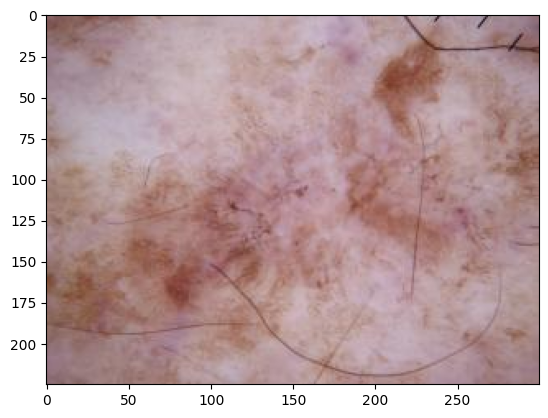

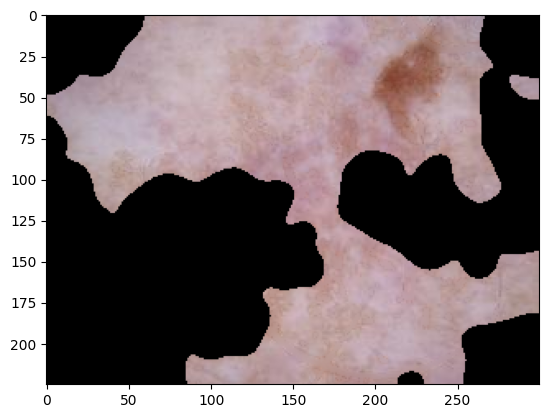

In [159]:
###################### TEST SEGMENTATION ######################

train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Test'

train_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Mask'
test_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Mask'

pourcentage = 0.01
l_dir_test_complet = os.listdir(test_path)
l_dir_test_mask = os.listdir(test_mask_path)
n_test_mask = len(l_dir_test_mask)
l_dir_test_mask = l_dir_test_mask[:int(n_test_mask*pourcentage)]


l_dir_train_complet = os.listdir(train_path)
l_dir_train_mask = os.listdir(train_mask_path)
n_train_mask = len(l_dir_train_mask)
l_dir_train_mask = l_dir_train_mask[:int(n_train_mask*pourcentage)]


n = 2562    # weird : 262
image_path1 = os.path.join(train_path, l_dir_train_complet[n])   
print(l_dir_train_complet[n])
image_path = os.path.join(train_path, "ISIC_0065202.jpg")
image = cv2.imread(image_path1, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

masked_image = create_and_apply_mask(image, dark_threshold=90,show1=False)

plt.imshow(masked_image)
plt.show()



In [63]:
### Importing Dataset ###
train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Test'

train_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Mask'
test_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Mask'

pourcentage = 1
l_dir_test_complet = os.listdir(test_path)
l_dir_test_mask = os.listdir(test_mask_path)
n_test_mask = len(l_dir_test_mask)
l_dir_test_mask = l_dir_test_mask[:int(n_test_mask*pourcentage)]


l_dir_train_complet = os.listdir(train_path)
l_dir_train_mask = os.listdir(train_mask_path)
n_train_mask = len(l_dir_train_mask)
l_dir_train_mask = l_dir_train_mask[:int(n_train_mask*pourcentage)]

# region : Ces deux boucles for permettent de ne séléctionner que les images qui ont un mask correspondant
## Je n'arrive pas à faire de masks pour le moment donc je me contente de ceux qui étaient déjà fournis
l_dir_train = []
l_dir_test = []
i_train = 0
for file_name in tqdm(l_dir_train_mask):
    numero_mask  = file_name.split('_')[1]
    numero_train = (l_dir_train_complet[i_train].split('_')[1]).split('.')[0]
    while not numero_mask == numero_train:
        i_train += 1
        numero_train = (l_dir_train_complet[i_train].split('_')[1]).split('.')[0]
    l_dir_train.append(l_dir_train_complet[i_train])

i_test = 0
for file_name in tqdm(l_dir_test_mask):
    numero_mask  = file_name.split('_')[1]
    numero_test = (l_dir_test_complet[i_test].split('_')[1]).split('.')[0]
    while not numero_mask == numero_test:
        i_test += 1
        numero_test = (l_dir_test_complet[i_test].split('_')[1]).split('.')[0]
    l_dir_test.append(l_dir_test_complet[i_test])
# endregion


train_images_path = [os.path.join(train_path, fn) for fn in l_dir_train]
test_images_path = [os.path.join(test_path, fn) for fn in l_dir_test]

train_masks_paths = [os.path.join(train_mask_path, mask_name) for mask_name in l_dir_train_mask]
test_masks_paths = [os.path.join(test_mask_path, mask_name) for mask_name in l_dir_test_mask]

# These two lines return list of masked and hair removed images
test_images = [LoadandTreat_images(image_path, mask_path) for image_path, mask_path in tqdm(zip(test_images_path, test_masks_paths))]
train_images = [LoadandTreat_images(image_path, mask_path) for image_path, mask_path in tqdm(zip(train_images_path, train_masks_paths))]




100%|██████████| 648/648 [00:00<00:00, 324255.43it/s]
16it [00:01,  8.88it/s]


KeyboardInterrupt: 

In [166]:
### Importing Dataset ###
train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\Test\Test'

pourcentage = 0.07    # 34 et 104 avec 0.005
l_dir_test = os.listdir(test_path)
l_dir_test_mask = [name for name in l_dir_test if 'seg' in name]
l_dir_test = [name for name in l_dir_test if 'seg' not in name]
n_test = len(l_dir_test)     ;   tiny_n_test = int(n_test*pourcentage)
tiny_l_dir_test = rd.sample(l_dir_test, tiny_n_test)

l_dir_train= os.listdir(train_path)
l_dir_train_mask = [name for name in l_dir_train if 'seg' in name]
l_dir_train = [name for name in l_dir_train if 'seg' not in name]
n_train = len(l_dir_train)   ;   tiny_n_train = int(n_train*pourcentage)
tiny_l_dir_train = rd.sample(l_dir_train, tiny_n_train)



def load_and_mask_nevus(l_dir, l_dir_masks, path, show = False):
    l_segmented_images = []
    mask_ID = [path.split('_')[1].split('.')[0] for path in l_dir_masks]
    
    for i in tqdm(range(len(l_dir))):
        image_path = os.path.join(path, l_dir[i])
        
        # We look for the corresponding mask if it exists
        name = image_path.split('\\')[-1]
        ID = name.split('.')[0]
        km = -1
        for k,mID in enumerate(mask_ID):
            if ID == mID :
                km = k
                break
        
        # wether we found a mask or not (km value), we apply the found mask or create one
        if km != -1:
            mask_path = os.path.join(path, l_dir_masks[km])
            image = LoadandTreat_images(image_path, mask_path, show=False) # we apply it if found
            l_segmented_images.append([image,ID])
        else:
            image=cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            try :
                image = create_and_apply_mask(image, dark_threshold=90) # else we create a mask and apply it
                l_segmented_images.append([image,ID])
            except:
                print('Error on image : ', ID)
                traceback.print_exc()
                plt.imshow(image)
                plt.show()
                continue
    
    return l_segmented_images



In [164]:
train_images = load_and_mask_nevus(tiny_l_dir_train,l_dir_train_mask , train_path, show = False)
test_images = load_and_mask_nevus(tiny_l_dir_test,l_dir_test_mask , test_path, show = False)



100%|██████████| 443/443 [01:07<00:00,  6.58it/s]


Train images :  1329
Test images :  443


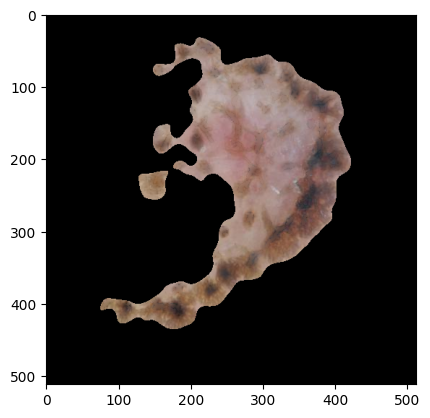

In [165]:
print('Train images : ', len(train_images))
print('Test images : ', len(test_images))  
image = train_images[51][0]
plt.imshow(image)
plt.show()


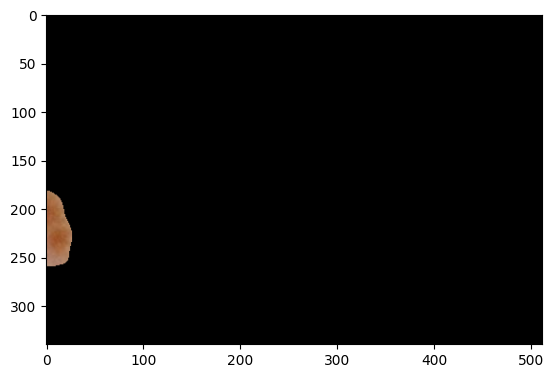

Indicateur de variété des couleurs : 0.16038837027532804
Asymétrie : 357.1436073207032
Irrégularité du contour : 0.8157835325663483
Distance moyenne au centre : 302.00334732828765


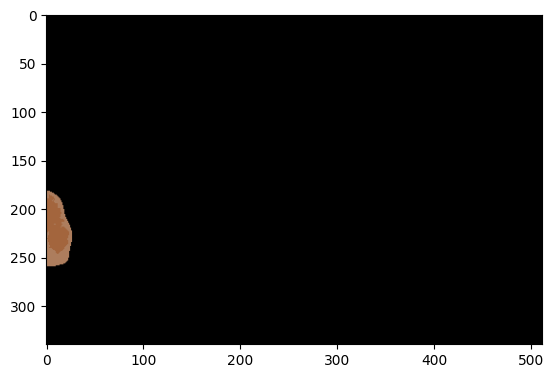

In [167]:
'''
C : Colors
D : Dimension of the lesion
A : Asymmetry
B : Border Irregularity
'''
# Exemple avec plusieurs couleurs sur l'image ISIC_000060.jpg, indice 14 je crois bien

def count_colors_proportion(image, bt=15):
    colors = []
    proportions = []
    h, w, _ = image.shape
    size = h * w
    for i in range(h):
        for j in range(w):
            pixel = image[i, j]
            color = pixel.tolist()
            if color in colors:
                proportions[colors.index(color)] += 1
            else:
                colors.append(color)
                proportions.append(1)

    # On met la couleur noir à 0
    for i,color in enumerate(colors):
        R = color[0] ; G = color[1] ; B = color[2]
        if R<bt and G<bt and B<bt:
            colors[i] = [0, 0, 0]
            # print('Black color found in the image !!!!!!!!!!!!')
            break
        if i == len(colors)-1:
            print('No black color found in the image !!!!!!!!!!!!')
            exit()
    
    pourcentages = [p / size for p in proportions]
    colorsAndProportions = list(zip(colors, pourcentages))
    return colorsAndProportions, size

def optimize_proportions(p, a=5, b=6):
    '''
    Le but de cette fonction est d'augmenter l'importance des proportions autour de 0.5 par rapport à celles proche de 0 et 1
    Ainsi on augmente l'importance des cas où il y a plusieurs couleurs dominantes.
    '''
    droite = p

    facteur = 1/((a/(a+b))**a * (b/(a+b))**b)
    cloche = facteur * p**a * (1 - p)**b  # cloche, nul et dérivée nulles en 0 et 1, maximum en fonction de a et b valant 1
    previous = 0.4 * cloche + droite

    Y = 10*p**3 - 15*p**4 + 6*p**5
    return Y

def voisinnage(image, i, j, large=False):
    '''
    Cette fonction renvoie les coordonnées des pixels voisins du pixel (i,j) dans l'image
    Si large est à True, on renvoie les 8 voisins, sinon on renvoie les 4 voisins directs
    On prend soin d'ajouter en premier les 4 voisins proches en premier pour que le parcour
    du contour soit automatiquement trié.
    '''
    voisins = []
    h, w, _ = image.shape
    # Check the four close neighbors first
    if i > 0: voisins.append((i-1, j))  # Up
    if j > 0: voisins.append((i, j-1))  # Left
    if i < h-1: voisins.append((i+1, j))  # Down
    if j < w-1: voisins.append((i, j+1))  # Right

    # If large is True, check the four diagonal neighbors
    if large:
        if i > 0 and j > 0: voisins.append((i-1, j-1))  # Up-Left
        if i > 0 and j < w-1: voisins.append((i-1, j+1))  # Up-Right
        if i < h-1 and j > 0: voisins.append((i+1, j-1))  # Down-Left
        if i < h-1 and j < w-1: voisins.append((i+1, j+1))  # Down-Right

    return voisins



def is_in_contour(image, i, j, large = True):
    '''
    Cette fonction permet de savoir si un pixel est dans le contour d'un nevus
    On regarde les voisins, si un voisin est noir ou que le pixel est sur le bord de l'image,
    alors le pixel est dans le contour.
    '''
    pixel = list(image[i,j])
    if (pixel != [0,0,0]) :
        voisins = voisinnage(image, i, j, large=large)
        # On vérifie que si le pixel est sur le bord de l'image en regardant le nombre de voisins (dépend de large)
        if large:
            if len(voisins) < 8:
                return True
        else :
            if len(voisins) < 4:
                return True
        
        for voisin in voisins:
            # On regarde si le voisin est noir
            if (list(image[voisin[0],voisin[1]]) == [0,0,0]) :
                return True
    return False

def contourner(image, i, j, contour):
    '''
    Cette fonction récursive permet de contourner un nevus
    '''
    voisins = voisinnage(image, i, j, large=True)
    to_check = []
    for voisin in voisins:
        i_v, j_v = voisin
        if (voisin not in contour)    and    (list(image[i_v,j_v]) != [0,0,0])    and    (is_in_contour(image, i_v, j_v,large=False)):
            contour.append((i_v, j_v))  # on ajoute le pixel au contour (on inverse les coordonnées pour avoir (i,j) et non (j,i) comme dans les images)
            contourner(image, i_v, j_v, contour)
    return contour

def contour_nevus(image, nevus):
    contour = []
    for i in nevus[0]:
        for j in nevus[1]:
            if list(image[i,j]) != [0,0,0]: # on trouve le premier pixel coloré, il appartient forcement au contour
                contour.append((i,j))
            if len(contour) > 0:            # dès qu'on a trouvé le premier élément, on entame le contournement
                contour = contourner(image, i, j, contour) # on entre dans la fonction récursive
                return contour

def trier_contour(image, contour):
    '''
    Cette fonction permet de trier les points du contour dans l'ordre de parcours
    '''
    contour_trie = [contour.pop(0)]
    tampon = []
    k_t = 0

    for k,point in enumerate(contour):
        i_t,j_t = contour_trie[k_t]
        voisins = voisinnage(image, i_t, j_t, large=True)
        if point in voisins:
            contour_trie.append(point)
            k_t += 1
        else:
            tampon.append(point)
        
        for point_t in tampon:
            i_t,j_t = contour_trie[k_t]
            voisins = voisinnage(image, i_t, j_t)
            if point_t in voisins:
                contour_trie.append(point_t)
                k_t += 1
                tampon.remove(point_t)
    return contour_trie

def contour_naif(image, nevus):
    '''Trop long'''
    contour = []
    m = len(image)
    n = len(image[0])
    for i in range(m):
        for j in range(n):
            if is_in_contour(image, i, j, large1=False):
                contour.append((i,j))
    return contour




def get_contour(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # contours_tuples = [[(point[0][1],point[0][0]) for point in contour] for contour in contours]

    # Return the first contour. If there are multiple segmented regions, this might need to be adjusted.
    
    return contours[0]









def ColorAndDimension(image, n_colors, max_hole_size=100):
    """Cette fonction permet de segmenter une image en fonction de ses couleurs dominantes et d'extraire des indicateurs.
    - On extrait les couleurs dominantes avec un k-means clustering, 
    - On remplit les trous de l'image pour chaque couleur dominante,
    - On superpose les images remplies pour obtenir une image segmentée.
    Après cela on calcule un indicateur rendant compte de la variété des couleurs dominantes.

    Args:
        image (numpy array): Image à segmenter
        n_colors (int): Correspond au nombre de couleurs dominantes à extraire on en extrait généralement 3 (noire, couleur1, couleur2)
        max_hole_size (int, optional): Taille au dela de laquelle on ne remplit pas les trous de l'image (éviter de recouvrir les autres couleurs internes). Defaults to 100.

    Returns:
        tuple of float: image segmentée, couleurs dominantes, (indicateur de variété des couleurs, écart type des couleurs de base), taille de l'image
    """
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)
    stdrd_deviation = np.sqrt(np.var(pixels, axis=0)) # Compute the standard deviation of each color channel

    #### ! K-means clustering and processing the mean-colored image ####
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    # Replace each pixel with its nearest color
    segmented_image = kmeans.cluster_centers_[kmeans.labels_]
    segmented_image = segmented_image.reshape(image.shape).astype(np.uint8)
    # Compute the mean color of each cluster
    mean_colors = kmeans.cluster_centers_.astype(np.uint8)

    filled_labels = np.zeros_like(kmeans.labels_)
    filled_images = np.zeros_like(image)
    areas = []
    # Create a binary image for each color area and stack them in the good order to fill the holes
    for i in range(n_colors):
        binary_image = (kmeans.labels_ == i).reshape(image.shape[:2])
        filled_image = sp.ndimage.binary_fill_holes(binary_image).astype(int)
        areas.append((i, np.sum(filled_image)))

    # Sort the areas in decreasing order of their sizes
    areas.sort(key=lambda x: x[1], reverse=True)
    
    # Apply the colors in the order of the areas
    total_area = len(pixels)
    for i, _ in areas:
        binary_image = (kmeans.labels_ == i).reshape(image.shape[:2])
        filled_image = sp.ndimage.binary_fill_holes(binary_image).astype(int)
        filled_images[filled_image == 1] = mean_colors[i]
        filled_labels[filled_image.flatten() == 1] = i

    colorsAndProportions, size = count_colors_proportion(filled_images)  # TODO: perte de temps ici, c'est le plus simple pour le moment

    #### ! Computing indicators to be returned ####
    black_index = []
    for sublist in colorsAndProportions:
        if [0, 0, 0] in sublist:
            black_index = sublist.index([0, 0, 0])
            break
    black_proportion = colorsAndProportions[black_index][1]
    non_black_proportion = 1 - black_proportion
    colorsAndProportions.pop(black_index)  # remove the black color
    colors = [color for color, _ in colorsAndProportions]

    # Computing the distance between the two most dominant colors
    R1, G1, B1 = colorsAndProportions[0][0]  ; pctg1 = colorsAndProportions[0][1]  
    R2, G2, B2 = colorsAndProportions[1][0]  ; pctg2 = colorsAndProportions[1][1]
    distance = np.sqrt((R1 - R2) ** 2 + (G1 - G2) ** 2 + (B1 - B2) ** 2)/255
    
    # Taking into account the proportion of the non black colors
    local_pourcentages = [pctg1/non_black_proportion, pctg2/non_black_proportion]
    min_pourcentage = min(local_pourcentages)
    different_colors_indicator = distance * optimize_proportions(2*min_pourcentage)
    
    return filled_images, colors, (different_colors_indicator,stdrd_deviation), size

def AsymetryAndBorderIrregularity2(image, show=False, show_loop=False):
    """Cette fonction calcul l'asymétrie et l'irrégularité du contour d'un nevus
    - asymétrie : moyenne des distances entre les points du contour et leur opposé par rapport au centre de gravité
    - irrégularité : écart-type des distances des points du contour au centre de gravité

    Args:
        image (numpy array): image de travaille en RGB
        show (bool, optional): afficher le calcul de l'irrégularité. Defaults to False.
        show_loop (bool, optional): afficher les images d'asymétrie. Defaults to False.

    Returns:
        tuple: asymétrie_moyenne, irrégularité_bord, distance_moyenne_au_centre
    """
    ## Calculer l'écart-type des distances des pixels du contour au centre de gravité
    non_null_pixels = np.where(np.any(image != [0, 0, 0], axis=-1))
    center = [np.mean(non_null_pixels[0]), np.mean(non_null_pixels[1])]
    
    # contour = contour_nevus(image, non_null_pixels) # attention, ici les coordonnées sont inversées si on veut les afficher
    # contour = clean_contour(image, contour)         # on nettoie le contour
    contour = get_contour(image)
    distances_to_center = [np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2) for i, j in contour]

    s = len(distances_to_center)
    mean_distance = np.mean(distances_to_center)
    # parts = [distances_to_center[i:i+s//12] for i in range(0, s, s//7)]  # on divise le contour en 12 parties et on calcul l'écart type pour chaque secteur avant de faire leur moyenne
    # border_irregularity = np.mean([np.std(part)/mean_distance for part in parts])

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregulrity)


    if show:
        # Assume points is your list of points
        # Create a sequence of numbers from 0 to 1
        colors = np.linspace(0, 1, len(contour))
        plt.scatter([j for i,j in contour], [i for i,j in contour], c=colors, cmap='viridis')
        plt.colorbar(label='Color scale')
        plt.show()

        circle = patches.Circle((center[1], center[0]), mean_distance, fill=False, color='red')
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.add_patch(circle)
        plt.show()
    
    
    ## Calculer l'asymétrie
    asymetries = []
    securite = int(len(contour)/3) 
    i_g = center[0]
    j_g = center[1]
    for k1,point1 in enumerate(contour):
        i_1 = point1[0]
        j_1 = point1[1]
        alpha1 = (j_1 - j_g) / (i_1 - i_g)

        delta_alpha_min = 1e15
        k_min = 0
        for k2,point2 in enumerate(contour):  # TODO : Y a probablement moyen de faire plus rapide, en parcourant les points proches de l'opposé.
            i_2 = point2[0]
            j_2 = point2[1]
            alpha2 = (j_2 - j_g) / (i_2 - i_g)
            delta_alpha = abs(alpha1 - alpha2)
            if (delta_alpha < delta_alpha_min)  and   (k2 not in range(k1-securite, k1+securite)): # on enlève le point 1 et ses voisins pour qu'il n'y ait qu'un seul minimum : le point opposé à 1 par rapport au centre
                delta_alpha_min = delta_alpha
                k_min = k2
        
        i_2 = contour[k_min][0]
        j_2 = contour[k_min][1]
        d1 = np.sqrt((i_1 - i_g) ** 2 + (j_1 - j_g) ** 2)
        d2 = np.sqrt((i_2 - i_g) ** 2 + (j_2 - j_g) ** 2)
        asymetry = abs(d1 - d2)/mean_distance
        asymetries.append(asymetry)
        if show_loop:
            plt.imshow(image)
            plt.scatter([j_g], [i_g], c='red')
            plt.scatter([j_1], [i_1], c='blue')
            plt.scatter(contour[k_min][1], contour[k_min][0], c='green')
            plt.show()
    asymetry = np.mean(asymetries)

    return asymetry*10, border_irregularity*10, mean_distance



def AsymmetryAndBorderIrregularity(image, show=False, show_loop=False):
    """Calculate the asymmetry and border irregularity of a nevus.

    Args:
        image (numpy array): The input image in RGB.
        show (bool, optional): Whether to show the calculation of the irregularity. Defaults to False.
        show_loop (bool, optional): Whether to show the asymmetry images. Defaults to False.

    Returns:
        tuple: The average asymmetry, border irregularity, and average distance to the center.
    """
    # Calculate the standard deviation of the distances from the contour pixels to the center of gravity
    non_null_pixels = np.where(np.any(image != [0, 0, 0], axis=-1))
    center = [np.mean(non_null_pixels[0]), np.mean(non_null_pixels[1])]

    contour = get_contour(image)
    distances_to_center = [np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2) for [[i, j]] in contour]

    mean_distance = np.mean(distances_to_center)

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)

    # Calculate the asymmetry
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Calculate the image moments
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(mask)

    # Use the second central moments to calculate the asymmetry
    mu20 = moments['mu20'] / moments['m00']
    mu02 = moments['mu02'] / moments['m00']
    mu11 = moments['mu11'] / moments['m00']

    # The difference between mu20 and mu02 can be used as a measure of asymmetry
    asymmetry = abs(mu20 - mu02)


    return asymmetry, compactness, mean_distance

[image,ID] = train_images[5]    # 67 sort de l'image

plt.imshow(image)
plt.show()
segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image, show=True)
print('Indicateur de variété des couleurs :', indicator)
#print('Ecart-type des couleurs de base :', std)
print('Asymétrie :', asymetry)
print('Irrégularité du contour :', border_irregularity)
print('Distance moyenne au centre :', mean_distance)
plt.imshow(segmented_image)
plt.show()




In [26]:

train_data_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\train_data.csv'
test_data_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\test_data.csv'
errors_train = []
errors_test = []

with open(train_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "indicator", "R1", "G1", "B1", "R2", "G2", "B2", "stdR", "stdG", "stdB", "asymetry", "border_irregularity", "mean_distance"])
    i=0
    for [image, ID] in tqdm(train_images):
        try :
            segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
            asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
            R1,G1,B1 = colors[0]
            R2,G2,B2 = colors[1]
            stdR,stdG,stdB = std
            data = [ID, indicator, R1, G1, B1, R2, G2, B2, stdR, stdG, stdB, asymetry, border_irregularity, mean_distance]
            writer.writerow(data)
        except Exception as e:
            print("erreur sur l'image", i)
            print("Error message : ", e)
            traceback.print_exc()
            errors_train.append(i)
        i+=1

with open(test_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", 'indicator', 'R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'stdR', 'stdG', 'stdB', 'asymetry', 'border_irregularity', 'mean_distance'])
    i=0
    for [image, ID] in tqdm(test_images):
        try :
            segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
            asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
            R1,G1,B1 = colors[0]
            R2,G2,B2 = colors[1]
            stdR,stdG,stdB = std
            writer.writerow([ID, indicator, R1, G1, B1, R2, G2, B2, stdR, stdG, stdB, asymetry, border_irregularity, mean_distance])
        except Exception as e:
            print("erreur sur l'image", i)
            print("Error message : ", e)
            traceback.print_exc()
            errors_test.append(i)
        i+=1

print("erreurs sur les images d'entrainement : ", errors_train)
print("erreurs sur les images de test : ", errors_test)


  1%|          | 29/3799 [00:08<18:15,  3.44it/s]


KeyboardInterrupt: 

In [168]:
train_data_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\train_data.csv'
test_data_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\test_data.csv'
errors_train = []
errors_test = []

### ! compute min and max of train data, assuming they are global
num_parameters = 10  # must adjust to actual number of parameters
min_vals = np.full(num_parameters, np.inf)
max_vals = np.full(num_parameters, -np.inf)
parameters = []

for [image, ID] in tqdm(train_images):
    try:
        segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
        asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
        R1,G1,B1 = colors[0]
        R2,G2,B2 = colors[1]
        stdR,stdG,stdB = std
        # data = [indicator, R1, G1, B1, R2, G2, B2, stdR, stdG, stdB, asymetry, border_irregularity, mean_distance]
        data = [indicator, R1, G1, B1, R2, G2, B2, asymetry, border_irregularity, mean_distance]
        min_vals = np.minimum(min_vals, data)
        max_vals = np.maximum(max_vals, data)
        parameters.append((ID, data))  # store the computed parameters
    except Exception as e:
        print("Error on image", ID)
        print("Error message : ", e)
        traceback.print_exc()
        errors_train.append(ID)

### ! Normalize and write to CSV the data
with open(train_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # writer.writerow(["ID", "indicator", "R1", "G1", "B1", "R2", "G2", "B2", "stdR", "stdG", "stdB", "asymetry", "border_irregularity", "mean_distance"])
    writer.writerow(["ID", "indicator", "R1", "G1", "B1", "R2", "G2", "B2", "asymetry", "border_irregularity", "mean_distance"])
    for ID, data in parameters:
        normalized_data = (data - min_vals) / (max_vals - min_vals)
        writer.writerow([ID] + normalized_data.tolist())


# same for test data, using min and max from training data
with open(test_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # writer.writerow(["ID", "indicator", "R1", "G1", "B1", "R2", "G2", "B2", "stdR", "stdG", "stdB", "asymetry", "border_irregularity", "mean_distance"])
    writer.writerow(["ID", "indicator", "R1", "G1", "B1", "R2", "G2", "B2", "asymetry", "border_irregularity", "mean_distance"])
    for [image, ID] in tqdm(test_images):
        try:
            segmented_image, colors, (indicator,std), size = ColorAndDimension(image, 3)
            asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
            R1,G1,B1 = colors[0]
            R2,G2,B2 = colors[1]
            stdR,stdG,stdB = std
            # data = [indicator, R1, G1, B1, R2, G2, B2, stdR, stdG, stdB, asymetry, border_irregularity, mean_distance]
            data = [indicator, R1, G1, B1, R2, G2, B2, asymetry, border_irregularity, mean_distance]
            normalized_data = (data - min_vals) / (max_vals - min_vals)
            writer.writerow([ID] + normalized_data.tolist())
        except Exception as e:
            print("Error on image", ID)
            print("Error message : ", e)
            traceback.print_exc()
            errors_test.append(ID)

print("Errors on training images: ", errors_train)
print("Errors on test images: ", errors_test)


 16%|█▋        | 217/1329 [00:35<02:41,  6.89it/s]Traceback (most recent call last):
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\3033694912.py", line 15, in <module>
    asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\942546283.py", line 364, in AsymmetryAndBorderIrregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)
                  ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
 16%|█▋        | 219/1329 [00:35<02:34,  7.19it/s]

Error on image ISIC_0010177
Error message :  float division by zero


 59%|█████▉    | 783/1329 [02:12<01:25,  6.36it/s]Traceback (most recent call last):
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\3033694912.py", line 15, in <module>
    asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\942546283.py", line 364, in AsymmetryAndBorderIrregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)
                  ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
 59%|█████▉    | 785/1329 [02:13<01:12,  7.52it/s]

Error on image ISIC_0027492
Error message :  float division by zero


 72%|███████▏  | 951/1329 [02:42<01:04,  5.88it/s]Traceback (most recent call last):
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\3033694912.py", line 15, in <module>
    asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\942546283.py", line 364, in AsymmetryAndBorderIrregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)
                  ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
 72%|███████▏  | 953/1329 [02:42<01:01,  6.09it/s]

Error on image ISIC_0062925
Error message :  float division by zero


  2%|▏         | 7/443 [00:01<01:38,  4.41it/s]Traceback (most recent call last):
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\3033694912.py", line 48, in <module>
    asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\942546283.py", line 364, in AsymmetryAndBorderIrregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)
                  ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
  2%|▏         | 8/443 [00:01<01:39,  4.39it/s]

Error on image ISIC_0063122
Error message :  float division by zero


  7%|▋         | 29/443 [00:06<01:51,  3.72it/s]Traceback (most recent call last):
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\3033694912.py", line 48, in <module>
    asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\942546283.py", line 364, in AsymmetryAndBorderIrregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)
                  ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
  7%|▋         | 30/443 [00:06<02:00,  3.43it/s]

Error on image ISIC_0054137
Error message :  float division by zero


 19%|█▊        | 82/443 [00:15<01:02,  5.80it/s]Traceback (most recent call last):
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\3033694912.py", line 48, in <module>
    asymetry, border_irregularity, mean_distance = AsymmetryAndBorderIrregularity(image)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc1\AppData\Local\Temp\ipykernel_20740\942546283.py", line 364, in AsymmetryAndBorderIrregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) - 1 # Indicator of border irregularity (0 for no irregularity)
                  ~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
 19%|█▊        | 83/443 [00:15<01:13,  4.88it/s]

Error on image ISIC_0068280
Error message :  float division by zero


100%|██████████| 443/443 [01:26<00:00,  5.14it/s]

Errors on training images:  ['ISIC_0010177', 'ISIC_0027492', 'ISIC_0062925']
Errors on test images:  ['ISIC_0063122', 'ISIC_0054137', 'ISIC_0068280']


In [169]:
####################### FUNCTIONS ############################################
##############################################################################

def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

def make_labels(labels):
  l_labels = []
  for i in range(len(labels)):
    l_labels.append([])
    for j in range(8):
      if labels[i] == j:
        l_labels[-1].append(1)
      else:
        l_labels[-1].append(0)
  return l_labels


In [170]:
########################### MAIN ##############################################
###############################################################################
body_part = {'nan':0, 'lower extremity':1, 'anterior torso':2, 'head/neck':3, 'posterior torso':4, 'upper extremity':5, 'palms/soles':6, 'oral/genital':7}
sex = {'nan':0, 'female':1, 'male':2}


# Importing the data
train_data = pd.read_csv(train_data_path)
metadata_train = pd.read_csv('metadataTrain.csv')

test_data = pd.read_csv(test_data_path)
metadata_test = pd.read_csv('metadataTest.csv')
test_results = pd.read_csv('SampleSubmission.csv')

# Merge the data
X_train = train_data.merge(metadata_train, left_on='ID', right_on='ID', how='inner')
X_test = test_data.merge(metadata_test, left_on='ID', right_on='ID', how='inner')
X_test = X_test.merge(test_results, left_on='ID', right_on='ID', how='inner')

# Map the 'POSITION' and 'SEX' columns
X_train['POSITION'] = X_train['POSITION'].map(body_part).fillna(0)
X_train['SEX'] = X_train['SEX'].map(sex).fillna(0)
X_train['AGE'] = X_train['AGE'].fillna(0)
X_test['POSITION'] = X_test['POSITION'].map(body_part).fillna(0)
X_test['SEX'] = X_test['SEX'].map(sex).fillna(0)
X_test['AGE'] = X_test['AGE'].fillna(0)


# Create the labels
Y_train = X_train['CLASS'] - 1
Y_test = X_test['CLASS'] - 1

# Drop the 'CLASS' column to create the features
X_train = X_train.drop(['ID','CLASS'], axis=1)
X_test = X_test.drop(['ID','CLASS'], axis=1)

# print(X_train.head(30))

# Save the data
train_data_path2 = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\train_class.csv'
test_data_path2 = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\original_data\test_class.csv'
Y_train.to_csv(train_data_path2, index=False)
Y_test.to_csv(test_data_path2, index=False)

X_train = X_train.values
Y_train = Y_train.values
X_test = X_test.values
Y_test = Y_test.values


In [177]:
############# Tentative avec un arbre de décision #############################
###############################################################################

Tree = DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=3, random_state=0)
Tree.fit(X_train,Y_train)

print('Score in the training set is {0}'.format(Tree.score(X_train,Y_train)))
print('Score in the test set is {0}'.format(Tree.score(X_test,Y_test)))

Score in the training set is 0.8981900452488688
Score in the test set is 0.12045454545454545


In [174]:
########################### MAIN ##############################################
###############################################################################
# Convert the data into PyTorch tensors and create a Dataset object
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).long()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).long()

''' to print stuff
print(X_train)

nan_indices = torch.isnan(X_train)

# Check if there are any NaNs
if nan_indices.any():
    print("NaN values found in X_train.")
    # Print the indices of NaNs
    nan_positions = torch.nonzero(nan_indices)
    print("NaN positions:\n", nan_positions)
else:
    print("No NaN values found in X_train.")

# Get the unique rows containing NaNs
nan_rows = nan_positions[:, 0].unique()

# Inspect rows with NaNs
print("Rows with NaN values in X_train:\n")
for row in nan_rows:
    print(f"Row {row}: {X_train[row]}")


assert not torch.isnan(X_train).any(), "NaNs in X_train"
assert not torch.isnan(Y_train).any(), "NaNs in Y_train"
assert not torch.isnan(X_test).any(), "NaNs in X_test"
assert not torch.isnan(Y_test).any(), "NaNs in Y_test"

'''

training_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

### Using GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the neural network architecture
d_in = X_train.shape[1]  # input dimension
n_1l = 100  # first layer
n_2l = 1000  # second layer
n_3l = 1000  # third layer
n_4l = 1000  # fourth layer
n_5l = 100  # fifth layer
n_out = len(np.unique(Y_train))  # output dimension


mon_model = nn.Sequential(
    nn.Linear(d_in, n_1l),
    nn.ReLU(),
    nn.Linear(n_1l, n_2l),
    nn.ReLU(),
    nn.Linear(n_2l, n_3l),
    nn.ReLU(),
    nn.Linear(n_3l, n_4l),
    nn.ReLU(),
    nn.Linear(n_4l, n_5l),
    nn.ReLU(),
    nn.Linear(n_5l, n_out)
)
mon_model = mon_model.to(device)


learning_rate = 0.001
n_epochs = 5
batch_size = 5

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(mon_model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Train the model
mon_model.train()
for epoch in range(n_epochs):
    train_loss=0.0
    all_labels = []
    all_predicted = []

    with tqdm(training_loader, unit="batch") as tepoch:
        for data, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = mon_model(data)
            _, predicted = torch.max(output, 1)  # Get class predictions
            all_predicted.extend(predicted.tolist())

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_labels.extend(labels.tolist())

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(training_loader.dataset)))
    print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),np.array(all_labels))))


cuda:0


Epoch 0: 100%|██████████| 266/266 [00:01<00:00, 149.06batch/s]


Epoch 0: Train Loss: 0.3373
Epoch 0: Train Accuracy: 0.4638


Epoch 1: 100%|██████████| 266/266 [00:01<00:00, 207.82batch/s]


Epoch 1: Train Loss: 0.3170
Epoch 1: Train Accuracy: 0.4811


Epoch 2: 100%|██████████| 266/266 [00:01<00:00, 209.14batch/s]


Epoch 2: Train Loss: 0.3065
Epoch 2: Train Accuracy: 0.4789


Epoch 3: 100%|██████████| 266/266 [00:01<00:00, 212.80batch/s]


Epoch 3: Train Loss: 0.2980
Epoch 3: Train Accuracy: 0.4887


Epoch 4: 100%|██████████| 266/266 [00:01<00:00, 198.60batch/s]

Epoch 4: Train Loss: 0.2885
Epoch 4: Train Accuracy: 0.4834


In [175]:
# Evaluate the model
mon_model.eval()
all_predicted = []
all_labels = []

print("entrainement terminé")
with tqdm(test_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
        data, labels = data.to(device), labels.to(device)
        output = mon_model(data)
        _, predicted = torch.max(output, 1)  # Get class predictions
        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

# all_predicted = [el+6 for el in all_predicted]

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)
print(all_predicted)
print(all_labels)

entrainement terminé


100%|██████████| 88/88 [00:00<00:00, 536.81batch/s]


Test Accuracy: 0.11136363636363636
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 